Install dependencies

In [1]:
!sudo apt-get update
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch 
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')




Deep RL Replay Buffer

In [3]:

class ReplayBuffer:
    def __init__(self, size, input_shape,dev):
        self.size = size
        self.counter = 0
        self.state_buffer = torch.zeros((self.size, input_shape))
        self.action_buffer = torch.zeros(self.size, dtype=torch.int64)
        self.reward_buffer = torch.zeros(self.size)
        self.new_state_buffer = torch.zeros((self.size, input_shape))
        self.terminal_buffer = torch.zeros(self.size)
        self.state_buffer.to(dev)
        self.action_buffer.to(dev)
        self.reward_buffer.to(dev)
        self.new_state_buffer.to(dev)
        self.terminal_buffer.to(dev)
        self.dev=dev;



    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch].to(self.dev)
        action_batch = self.action_buffer[batch].to(self.dev)
        reward_batch = self.reward_buffer[batch].to(self.dev)
        new_state_batch = self.new_state_buffer[batch].to(self.dev)
        done_batch = self.terminal_buffer[batch].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch
    def last_buffer(self, batch_size):
        state_batch = self.state_buffer[-1:-batch_size].to(self.dev)
        action_batch = self.action_buffer[-1:-batch_size].to(self.dev)
        reward_batch = self.reward_buffer[-1:-batch_size].to(self.dev)
        new_state_batch = self.new_state_buffer[-1:-batch_size].to(self.dev)
        done_batch = self.terminal_buffer[-1:-batch_size].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch


Default DQN arquitecture

In [4]:
class DQN(nn.Module):

    def __init__(self, inputs, outputs,dfactor):
        super(DQN, self).__init__()
        
        self.input_size=inputs;
        self.output_size=outputs;
        self.discount_factor=dfactor;
        nn.Module.__init__(self)
        self.layers = nn.Sequential(
           #Add your code here
           nn.Linear(in_features=4 , out_features=16),#16
           nn.LeakyReLU(),
           
        )

        self.advantage = nn.Sequential(
          nn.Linear(in_features=16, out_features=self.output_size),
        )
        self.value = nn.Sequential(
          nn.Linear(in_features=16, out_features=1),    
         )


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self,  x):
        if(useDueling):
            x=self.layers(x)
            advantage = self.advantage(x)
            value     = self.value(x)
            return value + advantage  - advantage.mean()
        else:
            return self.layers(x)

    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state).argmax()
     
    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
 
                return self.__call__(state).argmax()
        else:
            return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)



 

OpenAI Environment CartPole-v0

###    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
###    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
###    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
###    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
###    Reward:
        Reward is 1 for every step taken, including the termination step
###    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
###    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
        Episode length is greater than 200.
###     Solved Requirements:
        Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.

DQN movie generation (for visual evaluation in Google Colab)

In [5]:
def createMovie(Network,Filename):
    env = gym.make("CartPole-v0")
    envX = wrappers.Monitor(env, './videos/'+Filename,force=True)

    observation = envX.reset()

    i=0
    Network.eval()

    while True:
        envX.render()
        
        state=torch.Tensor(observation).to(device)
      
        action = Network.policy(state);
             
        observation, reward, done, info = envX.step(action.item()) 
        i=i+1;     
        if done: 
          break;

    envX.close()
    env.close();
    Network.train()
    mp4list = glob.glob('./videos/'+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Initialization and Parameters:


In [6]:


# Sim configuration
env = gym.make("CartPole-v0")
spec = gym.spec("CartPole-v0")


inputs=4
n_actions=2

#hyper-parameters
TotalEpisodes=1000;         # SE TOU A FAZZER PARA 1000 EPS 
MaxSteps=200
FreezeCounter=25
BatchSize=128
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.002
discount_factor=0.99
SaveAtCounter=25
LearningRate=0.001



#network DQN
policy_net = DQN(inputs, n_actions,discount_factor).to(device)
target_net = DQN(inputs, n_actions,discount_factor).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer(1000000, inputs,device);

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
loss = torch.nn.MSELoss()

# use these flags to enable Double DQN and Duelinng (Dueling DQN or Double Dueling DQN)
usedoubleDQN=False
useDueling=True


DQN training

In [7]:
def trainModel():
    if buffer.counter < BatchSize:
        return 0.0
         
    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer.sample_buffer(BatchSize)

    q_actual = torch.gather(policy_net(state_batch),1,action_batch.reshape(-1,1))
    with torch.no_grad():
        q_max_next = target_net(new_state_batch).max(1)[0].detach()
    q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch

    ll=loss(q_actual, q_target.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    ll.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return ll.item();

In [8]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()

loss_val,scores, episodes,events, avg_scores,avg_scores100,exploration = [],[],[], [],[], [], []

bestScore=-99999;
bestNet=copy.deepcopy(policy_net);
fx=0
for f in range(TotalEpisodes):
    done  = False
    score = 0.0
    state = torch.Tensor(env.reset()).to(device)
    if f % FreezeCounter == 0:
       print(str(f)+" of "+str(TotalEpisodes))
       target_net.load_state_dict(policy_net.state_dict())

    if f % SaveAtCounter == 0:
       torch.save(policy_net.state_dict(), "v2CartPole_"+str(f)+'_model.ckpt')
       createMovie(policy_net,"v2CartPole_"+str(f))

    for F in range(MaxSteps):
        action = policy_net.getPolicy(state,exploration_threshold)
        new_state, reward, done, _ = env.step(action.item())

        new_state=torch.Tensor(new_state).to(device);
        score += reward
        if(F<(MaxSteps-1)):  # avoid adding the last "good" example as done
            buffer.store_tuples(state, action, reward, new_state, done)
        state = new_state
        trainModel()
        if(done):
            break        
    exploration_threshold= exploration_threshold-exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min

    
    #log results
    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores100.append(np.mean(scores[-100:]))

    if(score>=bestScore):
        print(score,F+1,np.mean(scores[-100:]))
        bestScore=score;
        fx=f;
        bestNet=copy.deepcopy(policy_net);



torch.save(bestNet.state_dict(), "BestCartPoleDueling"+str(fx)+'_'+str(bestScore)+'_model.ckpt')
end = timer()
str(timedelta(seconds=(end-start)))

0 of 1000


20.0 20 20.0
31.0 31 25.5
34.0 34 28.333333333333332
36.0 36 22.533333333333335
45.0 45 23.352941176470587
69.0 69 24.238095238095237
25 of 1000


50 of 1000


75 of 1000


100 of 1000


79.0 79 23.94
125 of 1000


84.0 84 27.68
150 of 1000


109.0 109 28.94
160.0 160 35.56
175 of 1000


168.0 168 45.73
200 of 1000


189.0 189 54.4
200.0 200 57.01
200.0 200 62.27
225 of 1000


200.0 200 69.21
200.0 200 70.28
200.0 200 80.19
200.0 200 81.96
200.0 200 87.02
250 of 1000


200.0 200 95.28
200.0 200 97.16
200.0 200 101.71
200.0 200 102.96
200.0 200 104.84
275 of 1000


200.0 200 110.21
200.0 200 111.96
200.0 200 112.75
200.0 200 115.06
200.0 200 116.96
200.0 200 123.36
200.0 200 125.23
200.0 200 127.78
200.0 200 128.27
300 of 1000


200.0 200 133.88
200.0 200 134.81
200.0 200 136.5
200.0 200 139.04
200.0 200 141.21
200.0 200 141.32
200.0 200 141.85
200.0 200 142.96
200.0 200 144.65
200.0 200 146.07
200.0 200 146.85
200.0 200 146.47
200.0 200 148.22
200.0 200 149.79
325 of 1000


200.0 200 150.47
200.0 200 151.77
200.0 200 152.14
200.0 200 152.14
200.0 200 153.3
200.0 200 154.33
200.0 200 154.94
200.0 200 155.83
200.0 200 156.2
200.0 200 156.32
200.0 200 157.74
200.0 200 158.16
200.0 200 158.16
200.0 200 158.16
200.0 200 159.59
200.0 200 162.44
200.0 200 163.04
200.0 200 163.63
200.0 200 163.63
350 of 1000


200.0 200 165.01
200.0 200 166.12
200.0 200 167.43
200.0 200 167.88
200.0 200 166.67
200.0 200 167.5
200.0 200 168.99
200.0 200 170.01
200.0 200 170.58
200.0 200 170.58
200.0 200 171.1
200.0 200 171.1
200.0 200 171.41
200.0 200 173.06
200.0 200 174.27
200.0 200 174.76
200.0 200 174.65
200.0 200 174.65
200.0 200 174.65
200.0 200 174.65
200.0 200 175.12
200.0 200 176.11
375 of 1000


200.0 200 176.61
200.0 200 177.1
200.0 200 177.1
200.0 200 177.1
200.0 200 177.1
200.0 200 177.11
200.0 200 178.68
200.0 200 178.68
200.0 200 178.82
200.0 200 178.82
200.0 200 179.07
200.0 200 179.38
200.0 200 180.32
200.0 200 181.11
200.0 200 181.46
200.0 200 181.46
200.0 200 181.46
200.0 200 183.12
200.0 200 183.79
200.0 200 183.79
200.0 200 183.79
200.0 200 183.87
200.0 200 185.58
200.0 200 185.68
200.0 200 185.78
400 of 1000


200.0 200 186.27
200.0 200 186.6
200.0 200 186.6
200.0 200 186.6
200.0 200 186.69
200.0 200 186.69
200.0 200 186.8
200.0 200 187.3
200.0 200 187.3
200.0 200 187.46
200.0 200 187.46
200.0 200 187.46
200.0 200 187.46
200.0 200 188.21
200.0 200 188.21
200.0 200 188.21
200.0 200 188.43
200.0 200 188.43
200.0 200 188.43
200.0 200 189.75
200.0 200 189.75
200.0 200 189.89
200.0 200 189.89
200.0 200 189.9
200.0 200 189.9
425 of 1000


200.0 200 190.33
200.0 200 190.33
200.0 200 190.33
200.0 200 191.78
200.0 200 193.52
200.0 200 193.52
200.0 200 193.52
200.0 200 193.52
200.0 200 193.52
200.0 200 193.52
200.0 200 194.68
200.0 200 194.68
200.0 200 194.68
200.0 200 194.68
200.0 200 194.68
200.0 200 194.68
200.0 200 194.68
200.0 200 194.68
200.0 200 194.68
200.0 200 195.97
200.0 200 195.46
200.0 200 195.46
200.0 200 195.46
200.0 200 195.46
450 of 1000


200.0 200 196.27
200.0 200 196.27
200.0 200 196.27
200.0 200 196.27
200.0 200 196.27
200.0 200 198.05
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
475 of 1000


200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.4
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
500 of 1000


200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.39
200.0 200 199.38
200.0 200 199.37
525 of 1000


200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.91
200.0 200 199.91
200.0 200 199.91
200.0 200 199.91
200.0 200 199.91
550 of 1000


200.0 200 199.91
200.0 200 199.91
200.0 200 199.91
200.0 200 199.91
200.0 200 199.91
200.0 200 199.91
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
575 of 1000


200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
600 of 1000


200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.98
200.0 200 199.99
200.0 200 199.99
200.0 200 200.0
200.0 200 200.0
625 of 1000


200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
650 of 1000


200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
675 of 1000


200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
700 of 1000


200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
200.0 200 200.0
725 of 1000


200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.97
200.0 200 199.96
200.0 200 199.96
200.0 200 199.96
200.0 200 199.96
200.0 200 199.96
200.0 200 199.96
200.0 200 199.96
200.0 200 199.96
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
750 of 1000


200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.9
200.0 200 199.77
200.0 200 199.77
200.0 200 199.77
200.0 200 199.77
200.0 200 199.77
775 of 1000


200.0 200 199.66
200.0 200 199.57
200.0 200 199.52
200.0 200 199.52
200.0 200 199.37
200.0 200 199.37
200.0 200 199.37
200.0 200 199.3
200.0 200 199.21
200.0 200 199.21
200.0 200 199.09
200.0 200 199.09
200.0 200 199.09
200.0 200 199.09
200.0 200 199.09
200.0 200 199.09
800 of 1000


200.0 200 199.09
200.0 200 199.09
200.0 200 199.08
200.0 200 198.87
200.0 200 198.87
200.0 200 198.87
200.0 200 198.87
200.0 200 198.87
200.0 200 198.82
200.0 200 198.82
200.0 200 198.82
200.0 200 198.82
200.0 200 198.82
200.0 200 198.82
200.0 200 198.26
200.0 200 198.26
200.0 200 198.26
825 of 1000


200.0 200 198.09
200.0 200 198.09
200.0 200 198.09
200.0 200 198.09
200.0 200 198.09
200.0 200 198.09
200.0 200 198.09
200.0 200 198.09
200.0 200 198.09
200.0 200 198.09
200.0 200 198.1
200.0 200 198.1
200.0 200 198.1
200.0 200 198.1
200.0 200 198.1
200.0 200 198.1
200.0 200 198.1
200.0 200 198.1
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
850 of 1000


200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.14
200.0 200 198.21
200.0 200 198.27
200.0 200 198.27
200.0 200 198.27
200.0 200 198.27
200.0 200 198.27
200.0 200 198.27
875 of 1000


200.0 200 198.31
200.0 200 198.31
200.0 200 198.36
200.0 200 198.36
200.0 200 198.36
200.0 200 198.06
200.0 200 198.06
200.0 200 198.06
200.0 200 198.06
200.0 200 198.0
200.0 200 198.03
200.0 200 198.09
200.0 200 197.97
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
200.0 200 197.99
900 of 1000


200.0 200 197.98
200.0 200 197.55
200.0 200 197.18
200.0 200 197.18
200.0 200 197.18
200.0 200 197.18
200.0 200 197.04
200.0 200 196.71
200.0 200 196.71
200.0 200 196.71
200.0 200 196.71
200.0 200 196.83
200.0 200 196.88
200.0 200 196.88
200.0 200 196.62
925 of 1000


200.0 200 196.2
200.0 200 196.2
200.0 200 195.2
200.0 200 194.44
200.0 200 194.44
200.0 200 194.44
200.0 200 194.44
200.0 200 194.46
950 of 1000


200.0 200 193.15
200.0 200 193.15
200.0 200 193.15
200.0 200 193.15
200.0 200 192.85
200.0 200 192.85
200.0 200 188.78
200.0 200 188.78
200.0 200 188.78
200.0 200 188.78
975 of 1000


200.0 200 187.3
200.0 200 181.44


'0:15:48.327098'

Plot performance

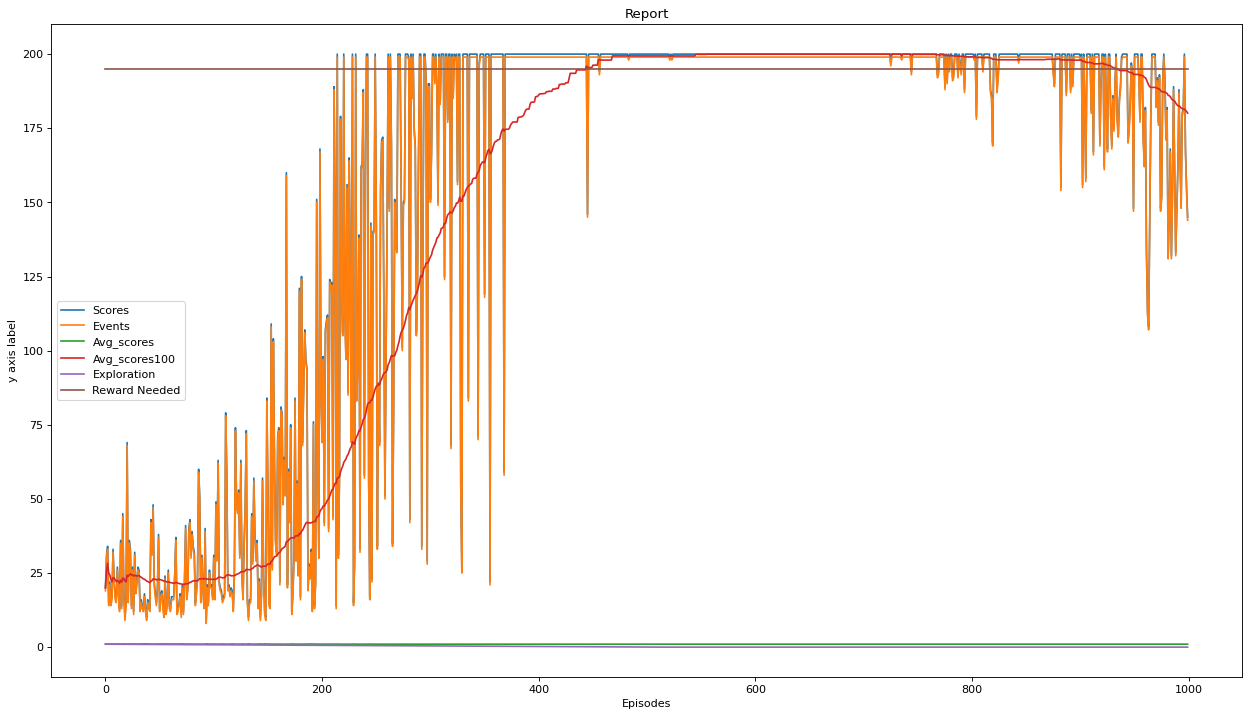

In [9]:
figure(figsize=(19.2, 10.8), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores100)
plt.plot(episodes, exploration)
a = []
a=[195 for i in range (TotalEpisodes)]
plt.plot(episodes,a)
plt.xlabel('Episodes')
plt.ylabel('y axis label')
plt.title('Report')
plt.legend(['Scores',  'Events', 'Avg_scores', 'Avg_scores100','Exploration','Reward Needed'])
plt.show()

In [10]:
#print(scores)
b=0
for i in  range (TotalEpisodes):
  b=b+scores[i]

print("Average score/epoch:",b/1000)
#print(scores)
b=0
num=0
i=975

for i in  range (25):
  b=b+scores[i+975]
  num=num+1

print("Average score/epoch:",b/25,"num=",num)

Average score/epoch: 156.239
Average score/epoch: 165.8 num= 25


In [11]:
#print(avg_scores100)
counter=0
episodio=0
index=[]
for i in range (TotalEpisodes):
  if(avg_scores100[i]>=195):
    counter+=1
    index.append(i)
#print(counter)
#percentagem
counter = (counter/TotalEpisodes) *100
print("First Episode to get reward needed:",index[0])
print("Percentage of Episodes with 195 or higher reward: %.2f" %counter,"%")

First Episode to get reward needed: 444
Percentage of Episodes with 195 or higher reward: 49.00 %


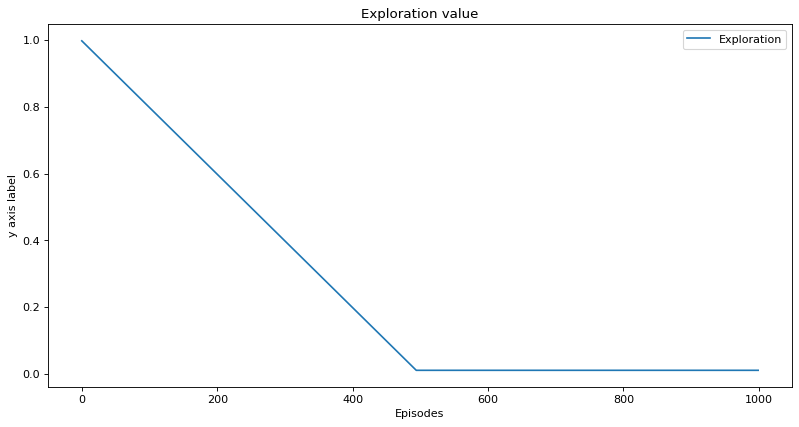

In [12]:
figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, exploration)
plt.xlabel('Episodes')
plt.ylabel('y axis label')
plt.title('Exploration value')
plt.legend(['Exploration'])
plt.show()

View Best Results

In [13]:
createMovie(bestNet,'bestNet')